# Text Mining Project - Stock Sentiment - Test Notebook

## *Predicting market behavior from tweets*

### Group 42

Carolina Pinto - 20240494 <br>
Fábio dos Santos - 20240678 <br>
Guilherme – 2024 <br>
Mariana – 2024 <br>

## Table of Contents
- [1. Import Libraries](#1-import-libraries)
- [2. Data Integration](#2-data-integration)
   - [2.1 Data Description](#21-data-description)
- [3. Data Content](#3-data-content)
- [4. Data Exploration](#4-data-exploration)
   - [4.1. Class Distribution](#41-class-distribution)
   - [4.2. Text Length](#42-text-length)
   - [4.3. Data Manipulation for Further Exploration](#43-data-manipulation-for-further-exploration)
   - [4.4. Most Frequent Words per Label](#44-most-frequent-words-per-label)
   - [4.5. Word Cloud by Label](#45-word-cloud-by-label)
- [5. Corpus Split](#5-corpus-split)
- [6. Data Preprocessing](#6-data-preprocessing)
- [7. Feature Engineering](#7-feature-engineering)
- [8. Classification Models](#8-classification-models)
- [9. Evaluation](#9-evaluation)

# 1. Import libraries

`Step 1` Import the required libraries.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
import re
from sklearn.model_selection import train_test_split
import string
from tqdm import tqdm

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import gensim.downloader
import gensim.downloader as api
from transformers import pipeline
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

from keras.models import Model
from keras import layers
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Masking, LSTM, Bidirectional, Dropout, Dense, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
import tensorflow.keras as keras
from keras_preprocessing.sequence import pad_sequences
import torch

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Download required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
pip install gensim

SyntaxError: invalid syntax (<ipython-input-2-1692567024>, line 1)

In [3]:
pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.8 MB/s eta 0:00:00


In [5]:
SEED=42

np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# Make PyTorch deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# TensorFlow
tf.random.set_seed(SEED)

## 1.1. Google Colab Setup

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jun 14 11:17:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')

# 2. Data Integration

`Step 2` Import the dataset __train.csv__ using the method **read_csv()** from pandas.

In [9]:
# df = pd.read_csv('../Project_Data/train.csv')

## 2.1. Data Description

`text`: tweets content. <br>
`label`: sentimental label, it can be bearish (0), bullish (1) or neutral (2).

# 3. Data Content

`Step 3` Check the first 5 rows of the dataset.

In [10]:
df.head(20)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
5,$FTI - TechnipFMC downgraded at Berenberg but ...,0
6,$GM - GM loses a bull https://t.co/tdUfG5HbXy,0
7,$GM: Deutsche Bank cuts to Hold https://t.co/7...,0
8,$GTT: Cowen cuts to Market Perform,0
9,$HNHAF $HNHPD $AAPL - Trendforce cuts iPhone e...,0


`Step 4` Check the number of rows and columns of the data frame.

In [11]:
df.shape

(9543, 2)

`Step 5` Check the features data types and info.

In [12]:
df.dtypes

,0
text,object
label,int64


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


#### Conclusions
- Our data is composed of **9543** observations and **2** columns. <br>
- Variable text is object and variable label is an integer as expected. <br>
- There are no null values in the observations. <br>
- Our tweets have a lot of "noise" letters and symbols like hashtags, dollar signs, links, punctuation and numbers. This should be adressed later on.

# 4. Data Exploration

`Step 6` Defining the colors to use in our visualizations for consistent representation (NOVA IMS official colors).

In [14]:
color_390 = (190/255, 214/255, 47/255)  # Pantone 390 C
color_431 = (92/255, 102/255, 108/255)  # Pantone 431 C

## 4.1. Class Distribution

`Step 7` Check Class Distribution (plot and percentage).

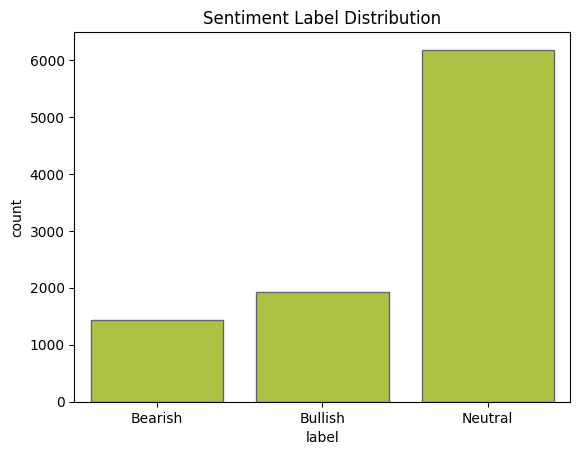

label
2    64.738552
1    20.150896
0    15.110552
Name: proportion, dtype: float64


In [15]:
sns.countplot(data=df, x='label', color=color_390, edgecolor=color_431)
plt.title("Sentiment Label Distribution")
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.show()

print(df['label'].value_counts(normalize=True) * 100)

- We can see that our labels are unbalanced, more than 60% is classified as "Neutral", 20% as "Bullish" and 15% as "Bearish".

## 4.2. Text Length

`Step 8` Check Text Length of the tweets per label.

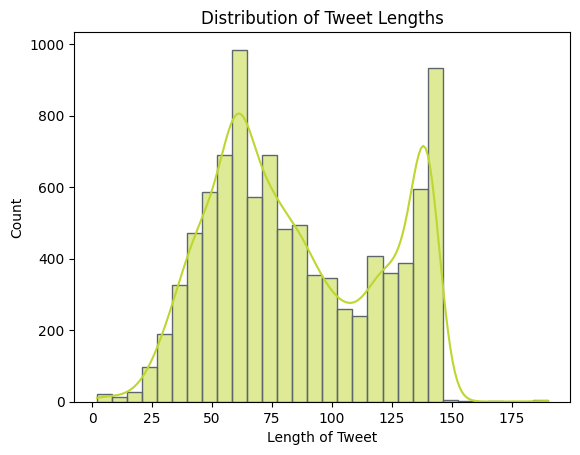

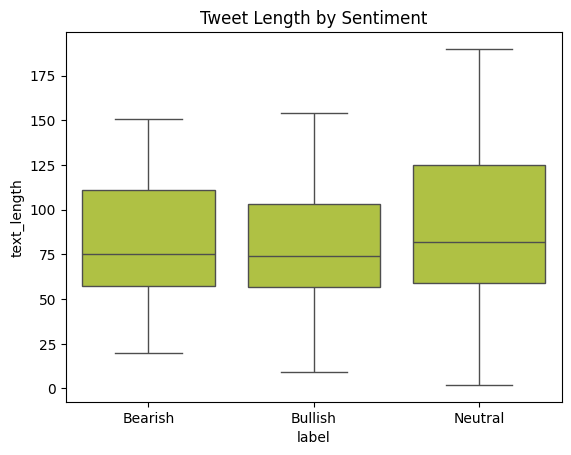

In [16]:
df['text_length'] = df['text'].apply(len)

sns.histplot(df['text_length'], bins=30, kde=True, color=color_390, edgecolor=color_431)
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Length of Tweet")
plt.show()

# Grouped by label
sns.boxplot(data=df, x='label', y='text_length', color=color_390)
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.title("Tweet Length by Sentiment")
plt.show()

- The different labels have a simillar distribution in terms of tweet length. <br>
- The tweets length are distributed in a normal distribution with two peaks at length between 60-65 and 140-145. <br>
- There are a lot of tweets (approximately 1000) with length between 60-65, and around 900 with length between 140-145. This represents approximately 19% of the data.

## 4.3. Data Manipulation for Further Exploration

- We want to check the most frequent words per label and the word clouds for each label. At this point our data is raw and we wouldn't get significant analysis. <br>
- For that reason in this section we will copy our dataset in order to do a small preprocessing (tokenize) and then perform the desired analysis. <br>
- After this data manipulation and the referred two analysis we will continue our work with corpus split and data preprocessing from the original dataset.

`Step 9` Using a copy of our dataset we tokenize the tweets in order to have a more accurate analysis.

In [17]:
df_copy = deepcopy(df)

stop_words = set(stopwords.words('english'))

# Preprocessing: basic cleaning and tokenization
def clean_and_tokenize(text):
    text = re.sub(r"http\S+|@\S+|[^a-zA-Z\s]", "", text)
    text = text.lower()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    return tokens

df_copy['tokens'] = df_copy['text'].apply(clean_and_tokenize)

df_copy

,text,label,text_length,tokens
0,$BYND - JPMorgan reels in expectations on Beyo...,0,77,"[bynd, jpmorgan, reels, expectations, beyond, ..."
1,$CCL $RCL - Nomura points to bookings weakness...,0,102,"[ccl, rcl, nomura, points, bookings, weakness,..."
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,94,"[cx, cemex, cut, credit, suisse, jp, morgan, w..."
3,$ESS: BTIG Research cuts to Neutral https://t....,0,59,"[ess, btig, research, cuts, neutral]"
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,71,"[fnko, funko, slides, piper, jaffray, pt, cut]"
...,...,...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2,136,"[weeks, gainers, losers, stoxx, europe, dec, e..."
9539,Tupperware Brands among consumer gainers; Unil...,2,67,"[tupperware, brands, among, consumer, gainers,..."
9540,vTv Therapeutics leads healthcare gainers; Myo...,2,89,"[vtv, therapeutics, leads, healthcare, gainers..."
9541,"WORK, XPO, PYX and AMKR among after hour movers",2,47,"[work, xpo, pyx, amkr, among, hour, movers]"


## 4.4. Most Frequent Words per Label

`Step 10` Check top 10 most frequent words per label.


Top 10 words for Bearish tweets:
stock: 148
us: 99
misses: 85
coronavirus: 79
oil: 78
economy: 68
market: 66
stocks: 64
price: 64
china: 63


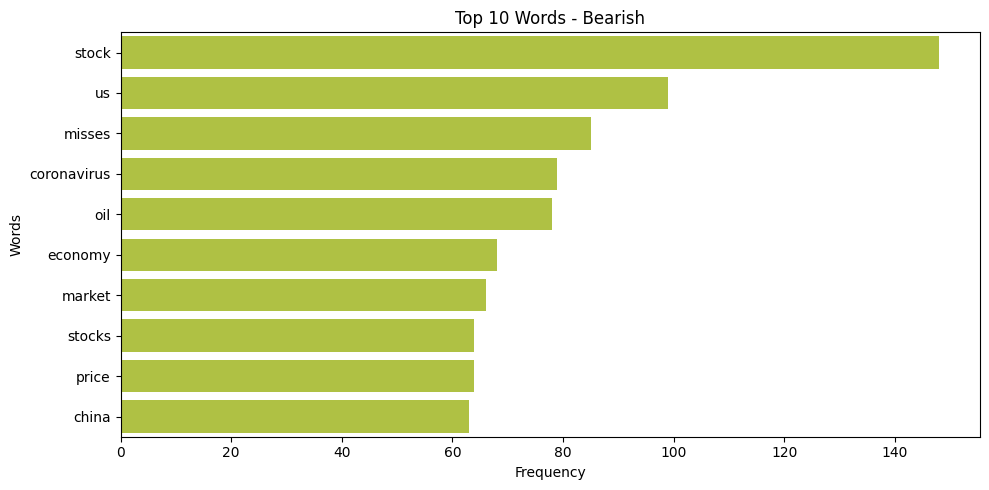


Top 10 words for Bullish tweets:
stock: 255
beats: 164
price: 137
us: 120
target: 117
stocks: 114
shares: 112
revenue: 106
market: 101
new: 97


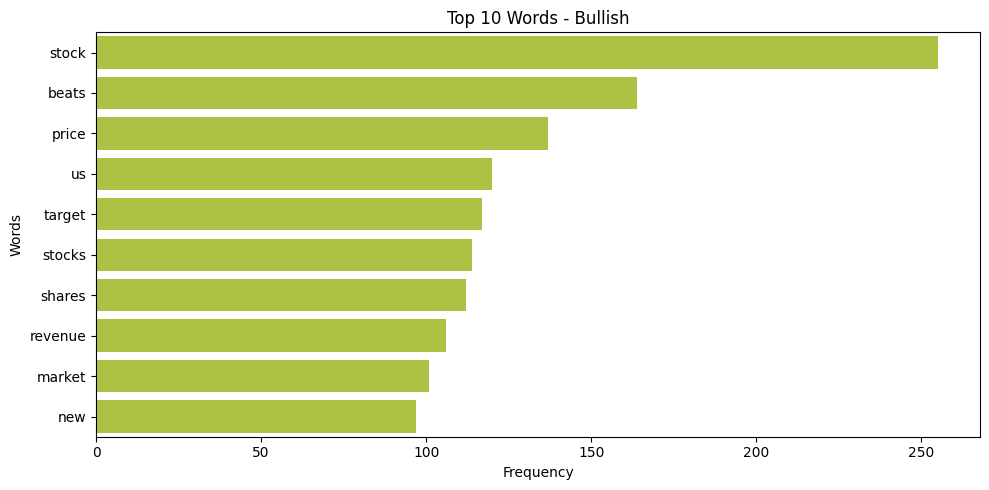


Top 10 words for Neutral tweets:
stock: 570
marketscreener: 376
results: 315
new: 285
earnings: 256
us: 233
says: 233
dividend: 225
reports: 222
inc: 195


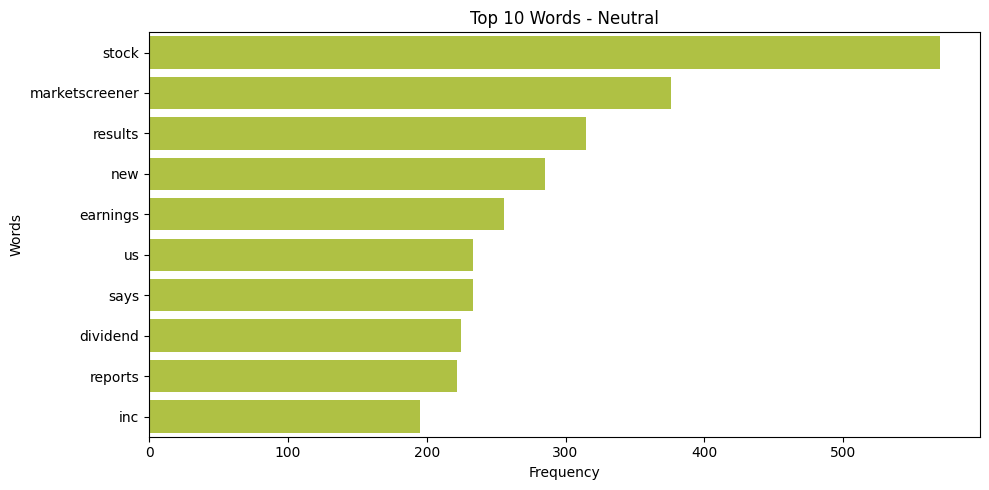

In [18]:
# Map labels to names
label_names = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}

# Show top 10 words per label
def get_top_words(df, label, top_n=10):
    all_words = [word for tokens in df[df['label'] == label]['tokens'] for word in tokens]
    most_common = Counter(all_words).most_common(top_n)

    print(f"\nTop {top_n} words for {label_names[label]} tweets:")
    for word, count in most_common:
        print(f"{word}: {count}")

    # Plot
    words, counts = zip(*most_common)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), color=color_390)
    plt.title(f"Top {top_n} Words - {label_names[label]}")
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.tight_layout()
    plt.show()

# Loop through each label
for label in sorted(df_copy['label'].unique()):
    get_top_words(df_copy, label, top_n=10)

In [19]:
df_copy.text_length.describe()

,text_length
count,9543.000000
mean,85.858325
std,35.138568
min,2.000000
25%,58.000000
50%,79.000000
75%,120.000000
max,190.000000


- All three labels have the same most common word as "stock" but also a good amount of the plural "stocks". <br>
- "us" also have a good representation in all the 3 labels. <br>
- Even though there is a significance difference between labels there are still some common words between them. <br>
- Neutral tweets don't have such a big gap between the top 5 most common words, which makes the words distribution more balanced. <br>
- The largest tweet have 190 words while the smallest one have 2. <br>
- In average the tweets have around 79 words.

## 4.5. Word Cloud by Label

`Step 11` Check Word Cloud of the different labels.

Word cloud for Bearish label:


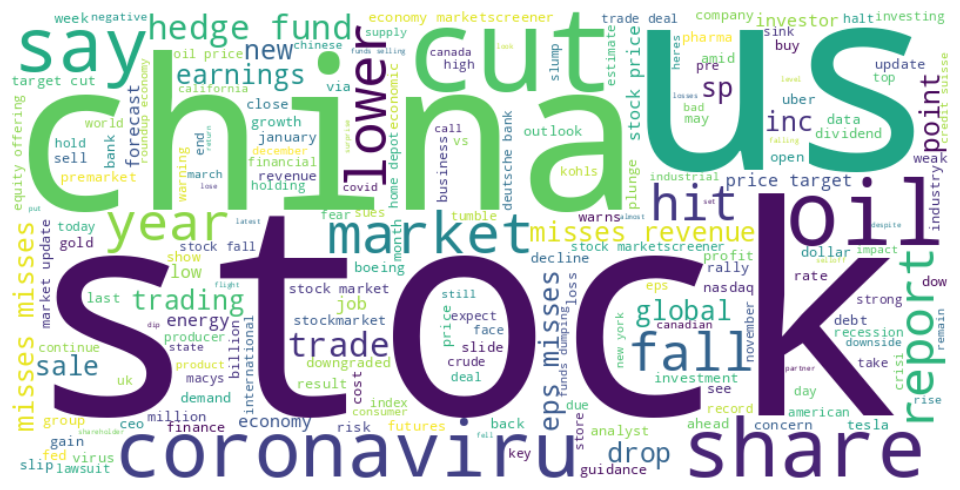

Word cloud for Bullish label:


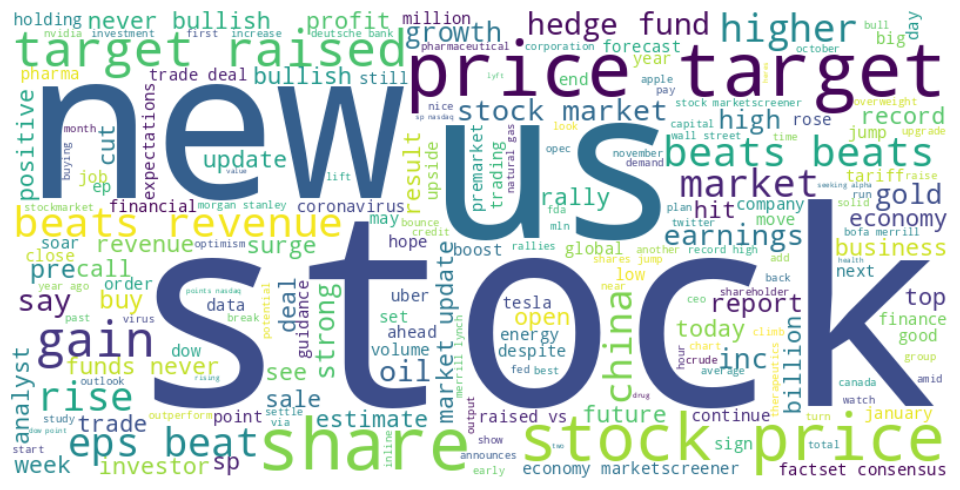

Word cloud for Neutral label:


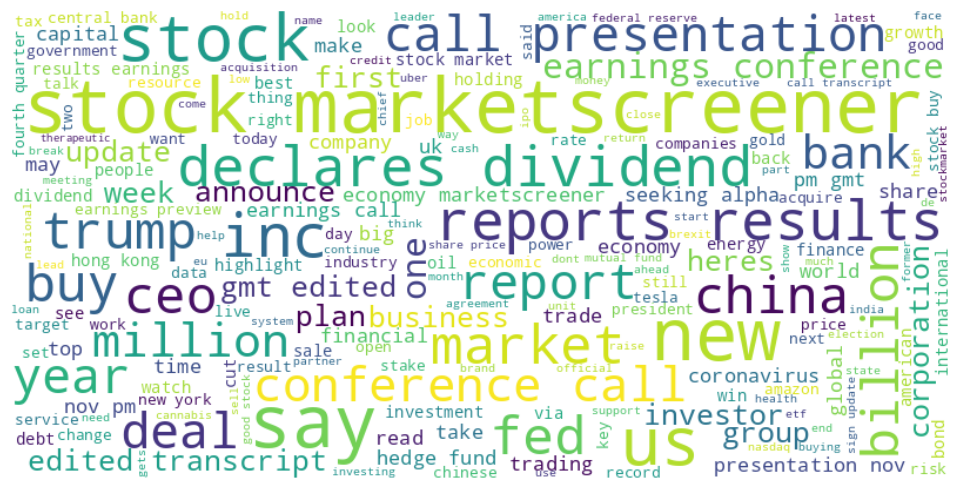

In [20]:
def plot_wordcloud(df, label, label_names):
    # Combine all tokens into one string
    text = " ".join(df[df['label'] == label]['tokens'].sum())

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap='viridis').generate(text)

    print(f"Word cloud for {label_names[label]} label:")

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate word clouds for each label
for label in sorted(df_copy['label'].unique()):
    plot_wordcloud(df_copy, label, label_names)

- As previously observed, “stock” appears as the most prominent word across all sentiment labels. However, in the Neutral label, it stands out less clearly due to a more even distribution among the top words. <br>
- Overall, the Neutral label exhibits a more balanced word frequency distribution compared to the Bearish and Bullish labels. This aligns with expectations: neutral tweets typically lack strong sentiment indicators, resulting in fewer dominant or sentiment-specific keywords that clearly classify the text as bullish or bearish.

# 5. Corpus Split

Since our corpus have less than 10000 rows we will split it in train, validation and test in a 80%/10%/10% split.

`Step 12` Create a copy of the original dataframe named **data**.

In [21]:
data = deepcopy(df)
data

,text,label,text_length
0,$BYND - JPMorgan reels in expectations on Beyo...,0,77
1,$CCL $RCL - Nomura points to bookings weakness...,0,102
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,94
3,$ESS: BTIG Research cuts to Neutral https://t....,0,59
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,71
...,...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2,136
9539,Tupperware Brands among consumer gainers; Unil...,2,67
9540,vTv Therapeutics leads healthcare gainers; Myo...,2,89
9541,"WORK, XPO, PYX and AMKR among after hour movers",2,47


__`Step 13`__ Create a varaible called `X` that store the values of the input features and `y` that stores the values of the target feature.

In [22]:
X = data.drop(columns=['label'], axis =1)
y = data['label']

__`Step 14`__ Split the data in train and validation set in a 80/20 split, with random_state = 42, stratification by y and with shuffle of the dataset.

In [23]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    random_state=SEED,
                                                    stratify=y,
                                                    shuffle=True
                                                    )

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    test_size=1/9,
                                                    random_state=SEED,
                                                    stratify=y_train_val,
                                                    shuffle=True
                                                    )

This first split was made for testing the preprocessing methods and the models. Model and feature engeeniring accessment we will use cross validation with the preprocessing inside.

# 6. Data Preprocessing

<span style="color:red">
PARA OPTIMIZAR O MODELO: </span> <br>
- Procurar diferentes lemmatizers e stemmers e testa-los em gridsearch para ver qual o melhor modelo <br>
- Procurar outras formas de preprocessing (corrigir typos, etc etc)<br>
- Temos de aplicar o preprocessement ao test?


__`Step 15`__ Create a function to do the data preprocessing. It includes:<br>
|Preprocessement                                  |
|------------------------------------|
| Lowercasing |
| Removes Regular Unwanted Expressions   |
| Remove Punctuation           |
| Tokenization |
| Remove Stop Words                    |
| Lemmatization |
| Stemming                    |

In [25]:
lemma = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

def preprocess(text_list, lemma = None, stemmer = None, word2vec=False):
    """
    Return the prepocessed text in a list "updates".

    Parameters:
    text_list : list to be preprocessed
    use_lemmatize : bool, optional
        If True, applies lemmatization to the tokens. Default is True.
    use_stemmer : bool, optional
        If True, applies stemming to the tokens. Default is False.
    """

    stop_words = set(stopwords.words('english'))

    updates = []

    for j in tqdm(text_list):

        text = j

        # Lower case text
        text = text.lower()

        # Remove Regular Unwanted Expressions
        text = re.sub(r"http\S+|www\S+|https\S+", '', text)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'\d+', '', text)

        # Remove Punctuation
        text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)

        # Tokenize the text
        tokens = word_tokenize(text)

        #Remove Stopwords
        tokens = [word for word in tokens if word not in stop_words]

        #Lemmatize
        if lemma:
            tokens = [lemma.lemmatize(word) for word in tokens]

        #Stemming
        if stemmer:
            tokens = [stemmer.stem(word) for word in tokens]

        # Rejoin tokens

        if word2vec:
            cleaned_text=tokens
        else:
            cleaned_text = " ".join(tokens)

        updates.append(cleaned_text)

    return updates

__`Step 16`__ Apply the preprocessement to X_train and X_val.

In [26]:
X_train['tokens'] = preprocess(X_train['text'])
X_train

100%|██████████| 7633/7633 [00:00<00:00, 11332.61it/s]


,text,text_length,tokens
447,Brazil's central bank stepped in to prop up th...,80,brazils central bank stepped prop currency
5073,Singapore Frees Listed Local Developers From H...,59,singapore frees listed local developers homesa...
5941,$RPAY - Repay Holdings buys Ventanex for up to...,75,rpay repay holdings buys ventanex
5479,WHO Pushes Countries to Share More Patient Det...,72,pushes countries share patient details combat ...
4654,How clean hydrogen could make the steel indust...,95,clean hydrogen could make steel industry less ...
...,...,...,...
6226,JPMorgan anticipates ‘disorderly’ year-end fun...,108,jpmorgan anticipates ‘ disorderly ’ yearend fu...
9186,$IMMU (+3.2% pre) FDA GRANTS FAST TRACK DESIGN...,140,immu pre fda grants fast track designation sac...
3590,Hero MotoCorp Q3 Results: Profit Beats Estimat...,68,hero motocorp q results profit beats estimates...
1261,Applied DNA Announces Issuance of U.S. Patent ...,123,applied dna announces issuance us patent prote...


In [27]:
X_val['tokens'] = preprocess(X_val['text'])
X_val

100%|██████████| 955/955 [00:00<00:00, 10934.59it/s]


,text,text_length,tokens
742,What the Fed meeting minutes could say about i...,82,fed meeting minutes could say interest rates p...
1218,Alibaba's books close early in $13.4 billion H...,71,alibabas books close early billion hong kong l...
497,Bank of Japan : Accounts (March 20) #BankofJap...,119,bank japan accounts march
4430,Europe's richest man is spending $1 billion on...,98,europes richest man spending billion departmen...
5829,$EFX - Four Chinese military hackers charged i...,86,efx four chinese military hackers charged equi...
...,...,...,...
6615,$AMTD: TD Ameritrade Investor Movement Index: ...,102,amtd td ameritrade investor movement index imx...
6387,President Trump reportedly walks away from vap...,53,president trump reportedly walks away vaping ban
8125,Why Hecla Mining Is a Buy,25,hecla mining buy
3209,News Highlights : Top Energy News of the Day #...,120,news highlights top energy news day


In [28]:
X_train_cleaned=preprocess(X_train['text'])
X_val_cleaned=preprocess(X_val['text'])
X_test_cleaned=preprocess(X_test['text'])

100%|██████████| 955/955 [00:00<00:00, 11897.76it/s]


# 7. Feature Engineering

This section contains different feature engineering approachs that our group tested (bag of words, word2vec and transformers).

In [44]:
dim_50 = 50
dim_100=100

## 7.1. Bag of Words (BoW)

__`Step 17`__ Apply BoW to the X_train already preprocessed.

In [38]:
bow = CountVectorizer(binary=True)
X_train_bow = bow.fit_transform(X_train_cleaned)
X_val_bow = bow.transform(X_val_cleaned)

__`Step 18`__ Visualize the 20 most common words in the BoW created.

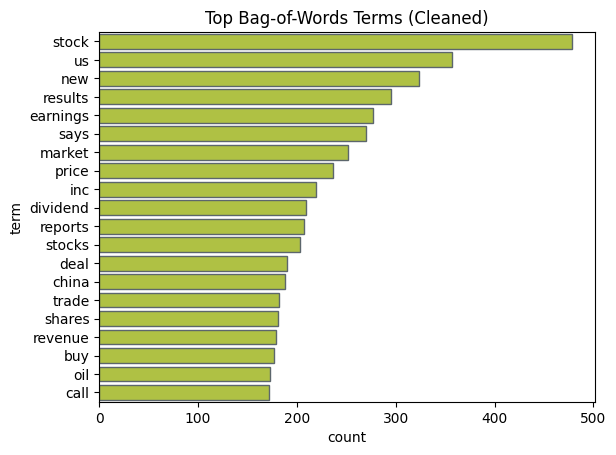

In [39]:
# Visualize top Bag of Words terms (Cleaned)
clean_bow_sum = np.array(X_train_bow.sum(axis=0)).flatten()
clean_terms = bow.get_feature_names_out() # in older versions is get_feature_names()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term', color=color_390, edgecolor=color_431)
plt.title("Top Bag-of-Words Terms (Cleaned)")
plt.show()

## 7.2. Word2vec - WIP

__`Step 19`__ Apply word2vec to the X_train already preprocessed.

In [45]:
X_train_cleaned_word2vec=preprocess(X_train['text'], word2vec=True)

100%|██████████| 7633/7633 [00:00<00:00, 8888.76it/s]


In [46]:
# Tokenize the tokens column for Word2Vec input
X_train_tokens = [text.split() for text in X_train['tokens']]
X_val_tokens = [text.split() for text in X_val['tokens']]

# model = Word2Vec(
#     sentences=corpus,
#     vector_size=5,    # size of the embedding vectors
#     window=2,         # context window size -  maximum distance between a target word and its context words
#     min_count=1,      # minimum word frequency that a word mus have in the corpus to be included in the modelx
#     sg=1              # 1 for skip-gram; 0 for CBOW (Predict the target word based on its context words.)
# )

# Train Word2Vec model on training
w2v_model_50 = Word2Vec(sentences=X_train_cleaned_word2vec, vector_size=dim_50, window=5, min_count=1, workers=4, sg=1)
w2v_model_100 = Word2Vec(sentences=X_train_cleaned_word2vec, vector_size=dim_100, window=5, min_count=1, workers=4, sg=1)

__`Step 20`__ Embeddings for each tweet in the corpus - average of the embeddings of each word in that tweet - suitable for models like KNN and Logistic Regression

In [47]:
def average_embedding(text, model, dim):
    words = text.split()
    vectors = []
    for word in words:
        if word in model:
            vectors.append(model[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

In [48]:
# These are embeddings with average (take the average of all the words in the tweet) - suitable for KNN and Logistic Regression
X_train_avgembeddings_from_scratch_50 = np.array([average_embedding(text, w2v_model_50.wv, dim=dim_50) for text in X_train_cleaned])
X_val_avgembeddings_from_scratch_50 = np.array([average_embedding(text, w2v_model_50.wv, dim=dim_50) for text in X_val_cleaned])

In [49]:
# These are embeddings with average (take the average of all the words in the tweet) - suitable for KNN and Logistic Regression
X_train_avgembeddings_from_scratch_100 = np.array([average_embedding(text, w2v_model_100.wv, dim=dim_100) for text in X_train_cleaned])
X_val_avgembeddings_from_scratch_100 = np.array([average_embedding(text, w2v_model_100.wv, dim=dim_100) for text in X_val_cleaned])

__`Step 21`__ Get the embeddings for each word - do not need to make the average - suitable for RNN and LSTM. These models accepts as inputs vectors of vectors

In [50]:
def corpus2vec(corpus, w2v):
    index_set = set(w2v.index_to_key)  # List of all words/vocabulary in the model
    word_vec = w2v.get_vector           # Creates a short cut that retrieves the embedding method for a given word
    return [
        [word_vec(word) for word in doc.split() if word in index_set]
        for doc in tqdm(corpus)
    ]

In [51]:
# these are embeddings where each word is a vector (not computed the average across words) - suitable for RNN and LSTM
X_train_embeddings_from_scratch_50 = corpus2vec(X_train_cleaned, w2v_model_50.wv)
X_val_embeddings_from_scratch_50 = corpus2vec(X_val_cleaned, w2v_model_50.wv)

100%|██████████| 955/955 [00:00<00:00, 9806.11it/s]


In [52]:
# these are embeddings where each word is a vector (not computed the average across words) - suitable for RNN and LSTM
X_train_embeddings_from_scratch_100 = corpus2vec(X_train_cleaned, w2v_model_100.wv)
X_val_embeddings_from_scratch_100 = corpus2vec(X_val_cleaned, w2v_model_100.wv)

100%|██████████| 955/955 [00:00<00:00, 11005.16it/s]


## 7.3. Word Vectors with Glove (Pretrained Word Vectors)

__`Step 21`__ Download the pretrained word vectors.

In [ ]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
# we will use the one regarding twitter
glove_model_50 = gensim.downloader.load(f'glove-twitter-{dim_50}')
glove_model_100 = gensim.downloader.load(f'glove-twitter-{dim_100}')

In [ ]:
X_train_avgembeddings_glove_50 = np.array([average_embedding(text, glove_model_50, dim=dim_50) for text in X_train_cleaned])
X_val_avgembeddings_glove_50 = np.array([average_embedding(text, glove_model_50, dim=dim_50) for text in X_val_cleaned])

In [ ]:
X_train_avgembeddings_glove_100 = np.array([average_embedding(text, glove_model_100, dim=dim_100) for text in X_train_cleaned])
X_val_avgembeddings_glove_100 = np.array([average_embedding(text, glove_model_100, dim=dim_100) for text in X_val_cleaned])

In [ ]:
X_train_embeddings_glove_50 = corpus2vec(X_train_cleaned, glove_model_50)
X_val_embeddings_glove_50 = corpus2vec(X_val_cleaned, glove_model_50)

100%|██████████| 955/955 [00:00<00:00, 27430.65it/s]


In [ ]:
X_train_embeddings_glove_100 = corpus2vec(X_train_cleaned, glove_model_100)
X_val_embeddings_glove_100 = corpus2vec(X_val_cleaned, glove_model_100)

100%|██████████| 955/955 [00:00<00:00, 25666.30it/s]


## 7.3. Transformers (Encoders for Feature Engenineering)

Transformers Tested:

-------------- From Class -----------------
- Distilbert base uncased
- Roberta Base
- XLM Roberta Base

-------------- Out of Class ---------------
- Finbert
- Dislilbert Base Cased

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

MODEL1 = "assemblyai/distilbert-base-uncased-sst2"
MODEL2 = "cardiffnlp/twitter-roberta-base-sentiment"
MODEL3 = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
MODEL4 = "ProsusAI/finbert"
MODEL5 = "distilbert-base-cased"

In [ ]:
model1 = pipeline("feature-extraction", model=MODEL1, tokenizer=MODEL1, batch_size=16, truncation=True)
# model2 = pipeline("feature-extraction", model=MODEL2, tokenizer=MODEL2, batch_size=16, truncation=True)
# model3 = pipeline("feature-extraction", model=MODEL3, tokenizer=MODEL3, batch_size=16, truncation=True)
# model4 = pipeline("feature-extraction", model=MODEL4, tokenizer=MODEL4, batch_size=16, truncation=True)
# model5 = pipeline("feature-extraction", model=MODEL5, tokenizer=MODEL5, batch_size=16, truncation=True)

Device set to use cpu


In [ ]:
def generate_embeddings(
    texts,
    embeddings_model,
    for_sequence_model=False,
    desc="Generating Embeddings"
):
    """
    Generates either CLS embeddings (1 per text) or full token embeddings (sequence) for each input text.

    Args:
        texts (list of str): List of input texts.
        embeddings_model (callable): Hugging Face pipeline("feature-extraction", ...).
        use_cls (bool): If True, use the CLS token embedding; if False, use mean pooling.
        for_sequence_model (bool): If True, return full token-level embeddings (for RNNs).
        desc (str): tqdm progress bar description.

    Returns:
        If for_sequence_model:
            List[torch.Tensor]: Each tensor is [seq_len, hidden_dim].
        Else:
            torch.Tensor: Tensor of shape [num_texts, hidden_dim].
    """
    processed = []

    for text in tqdm(texts, desc=desc):
        output = embeddings_model(text)  # list[list[list]]
        token_embeddings = output[0]  # get token vectors from the first (and only) item in batch
        token_embeddings = torch.tensor(token_embeddings)  # shape: [seq_len, hidden_dim]

        if for_sequence_model:
            processed.append(token_embeddings)  # shape: [seq_len, hidden_dim]
        else:
            summary_vector = token_embeddings[0]  # [CLS] token embedding
            processed.append(summary_vector)

    if for_sequence_model:
        return processed
    else:
        return torch.stack(processed)  # shape: [num_texts, hidden_dim]


In [ ]:
X_train_avgembeddings_transformer1=generate_embeddings(X_train_cleaned, model1)
X_val_avgembeddings_transformer1=generate_embeddings(X_val_cleaned, model1)
# X_train_avgembeddings_transformer2=generate_embeddings(X_train_cleaned, model2)
# X_val_avgembeddings_transformer2=generate_embeddings(X_val_cleaned, model2)
# X_train_avgembeddings_transformer3=generate_embeddings(X_train_cleaned, model3)
# X_val_avgembeddings_transformer3=generate_embeddings(X_val_cleaned, model3)
# X_train_avgembeddings_transformer4=generate_embeddings(X_train_cleaned, model4)
# X_val_avgembeddings_transformer4=generate_embeddings(X_val_cleaned, model4)
# X_train_avgembeddings_transformer5=generate_embeddings(X_train_cleaned, model5)
# X_val_avgembeddings_transformer5=generate_embeddings(X_val_cleaned, model5)

Generating Embeddings: 100%|██████████| 1909/1909 [00:48<00:00, 39.36it/s]


In [ ]:
X_train_embeddings_transformer1=generate_embeddings(X_train_cleaned, model1, for_sequence_model=True)
X_val_embeddings_transformer1=generate_embeddings(X_val_cleaned, model1, for_sequence_model=True)
# X_train_embeddings_transformer2=generate_embeddings(X_train_cleaned, model2, for_sequence_model=True)
# X_val_embeddings_transformer2=generate_embeddings(X_val_cleaned, model2, for_sequence_model=True)
# X_train_embeddings_transformer3=generate_embeddings(X_train_cleaned, model3, for_sequence_model=True)
# X_val_embeddings_transformer3=generate_embeddings(X_val_cleaned, model3, for_sequence_model=True)
# X_train_embeddings_transformer4=generate_embeddings(X_train_cleaned, model4, for_sequence_model=True)
# X_val_embeddings_transformer4=generate_embeddings(X_val_cleaned, model4, for_sequence_model=True)
# X_train_embeddings_transformer5=generate_embeddings(X_train_cleaned, model5, for_sequence_model=True)
# X_val_embeddings_transformer5=generate_embeddings(X_val_cleaned, model5, for_sequence_model=True)

Generating Embeddings: 100%|██████████| 1909/1909 [00:27<00:00, 68.88it/s]


# 8. Classification Models

X_train_avgembeddings_(...) - for KNN and logistic regression models. Each tweet is a vector with the average embeddings of each word
X_train_embeddings_(...) - for RNN and LTSM. Each tweet is a vector of vector. Each word is an embedding, all embaddings have the same size. It is needed padding, done below in the RNN and LSTM section.

## 8.1. KNN Classifier, Logistic Regression

Defining configurations and functions

In [ ]:
feature_sets = {
    "BoW": (X_train_bow, X_val_bow),
    "Word2Vec": (X_train_avgembeddings_from_scratch_100, X_val_avgembeddings_from_scratch_100),
    "GloVe": (X_train_avgembeddings_glove_100, X_val_avgembeddings_glove_100),
    # "distilbert-base-uncased": (X_train_avgembeddings_transformer1, X_val_avgembeddings_transformer1),
    # "finbert": (X_train_avgembeddings_transformer4, X_val_avgembeddings_transformer4)
}

In [ ]:
knn_configs = [
    {"n_neighbors": 10, "metric": "cosine", "weights": "uniform"},
    {"n_neighbors": 5, "metric": "cosine", "weights": "distance"},
    {"n_neighbors": 10, "metric": "cosine", "weights": "distance"},
    {"n_neighbors": 5, "metric": "euclidean", "weights": "distance"}
]

In [ ]:
logreg_configs = [
    {"max_iter": 1000, "solver": "lbfgs"},
    {"max_iter": 1000, "solver": "saga"},
    {"max_iter": 1000, "solver": "liblinear"}
]

In [ ]:
def evaluate_and_print(model, X_train, y_train, X_val, y_val, model_name, rep_name, config):
    print("--------------------------------------------------------------------------------------")
    print(f"\n Model: {model_name}, Embedding: {rep_name}, Config: {config}")
    print("--------------------------------------------------------------------------------------")

    results = {}

    # --- TRAINING METRICS ---
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_report = classification_report(y_train, y_train_pred, target_names=['bearish', 'bullish', 'neutral'], output_dict=True)

    print("\n📘 TRAINING METRICS")
    print(f"Accuracy: {train_acc:.4f}")
    print(f"\nMacro Avg F1-score: {train_report['macro avg']['f1-score']:.4f}")

    # --- VALIDATION METRICS ---
    y_val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_report = classification_report(y_val, y_val_pred, target_names=['bearish', 'bullish', 'neutral'], output_dict=True)

    print("\n📗 VALIDATION METRICS")
    print(f"Accuracy: {val_acc:.4f}")
    print(f"\nMacro Avg F1-score: {val_report['macro avg']['f1-score']:.4f}")

    # --- Return all scores for storage ---
    results = {
        "model": model_name,
        "embedding": rep_name,
        "config": config,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "train_f1": train_report["macro avg"]["f1-score"],
        "val_f1": val_report["macro avg"]["f1-score"],
        "f1_gap": train_report["macro avg"]["f1-score"] - val_report["macro avg"]["f1-score"]
    }

    return results

### KNN

In [ ]:
results_final = []

for rep_name, (X_train, X_val) in feature_sets.items():
    for config in knn_configs:
        # Initialize model with current hyperparameters
        knn = KNeighborsClassifier(**config)
        # Train and predict
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_val)
        # Evaluate
        results = evaluate_and_print(knn, X_train, y_train, X_val, y_val, "KNN", rep_name, config)

        config_str = ', '.join(f"{k}={v}" for k, v in sorted(config.items()))

        results_final.append({
            "prepro + model": rep_name+ " " +config_str,
            "train_f1": results["train_f1"],
            "val_f1": results["val_f1"]
        })

--------------------------------------------------------------------------------------

 Model: KNN, Embedding: BoW, Config: {'n_neighbors': 10, 'metric': 'cosine', 'weights': 'uniform'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.7998

Macro Avg F1-score: 0.7081

📗 VALIDATION METRICS
Accuracy: 0.7382

Macro Avg F1-score: 0.6124
--------------------------------------------------------------------------------------

 Model: KNN, Embedding: BoW, Config: {'n_neighbors': 5, 'metric': 'cosine', 'weights': 'distance'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.9976

Macro Avg F1-score: 0.9969

📗 VALIDATION METRICS
Accuracy: 0.7487

Macro Avg F1-score: 0.6387
--------------------------------------------------------------------------------------

 Model: KNN, Embedding: BoW, Config: {'n_neighbors': 10, 'metric': 'cosine', 'weights': 'distance'}


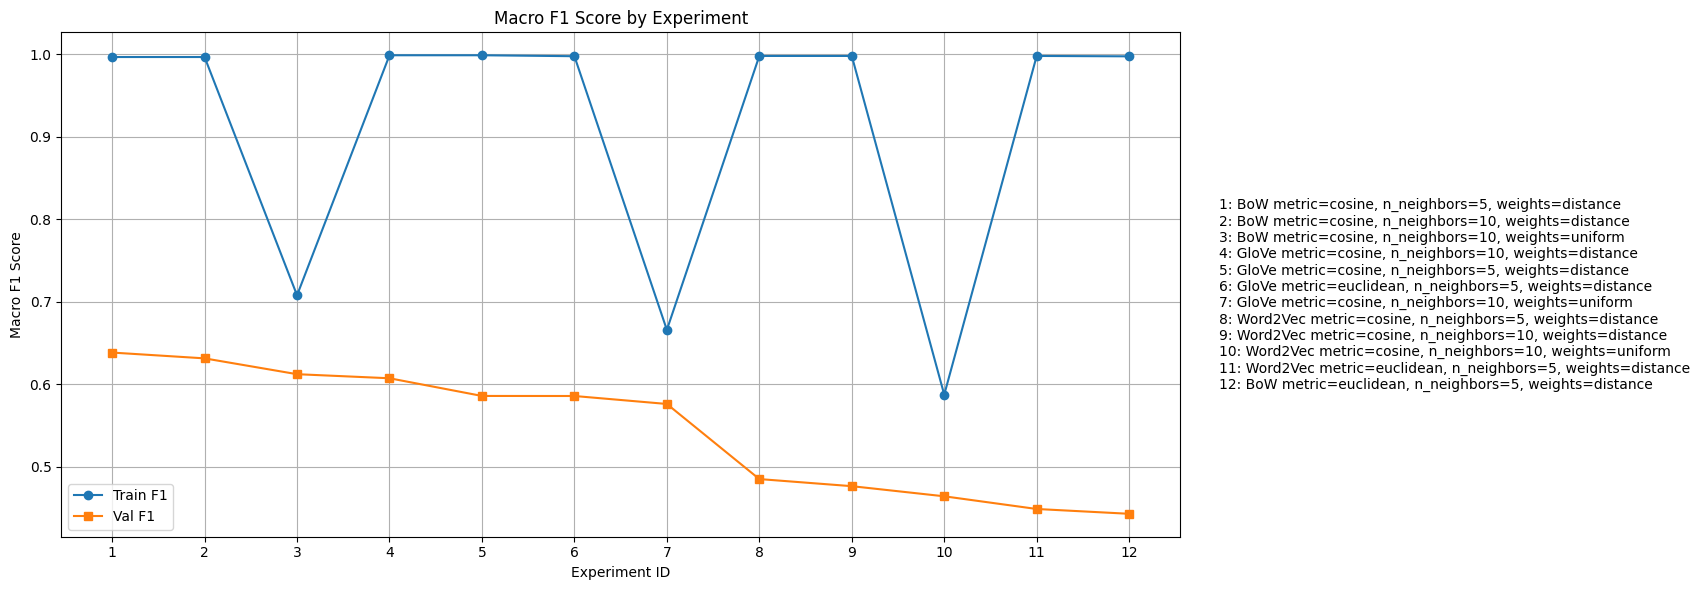

In [ ]:
# Convert results_final to a DataFrame
df_results = pd.DataFrame(results_final)

# Sort by validation F1 if desired
df_results = df_results.sort_values("val_f1", ascending=False).reset_index(drop=True)

# Create numerical labels for x-axis
df_results["experiment_id"] = range(1, len(df_results) + 1)

# Create mapping for legend
legend_labels = [
    f"{i+1}: {name}" for i, name in enumerate(df_results["prepro + model"])
]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_results["experiment_id"], df_results["train_f1"], marker='o', label="Train F1")
plt.plot(df_results["experiment_id"], df_results["val_f1"], marker='s', label="Val F1")

# Labels and formatting
plt.xticks(df_results["experiment_id"])  # just numbers on x-axis
plt.xlabel("Experiment ID")
plt.ylabel("Macro F1 Score")
plt.title("Macro F1 Score by Experiment")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Add a custom legend as text box
legend_text = "\n".join(legend_labels)
plt.gcf().text(1.02, 0.5, legend_text, fontsize=10, va='center')  # side legend

# Show plot
plt.show()

### Logistic

In [ ]:
results_logreg = []
from sklearn.linear_model import LogisticRegression

for rep_name, (X_train, X_val) in feature_sets.items():
    for config in logreg_configs:
        clf = LogisticRegression(**config)
        clf.fit(X_train, y_train)
        results = evaluate_and_print(clf, X_train, y_train, X_val, y_val, "Logistic Regression", rep_name, config)
        config_str = ', '.join(f"{k}={v}" for k, v in sorted(config.items()))

        results_logreg.append({
            "prepro + model": rep_name+ " " +config_str,
            "train_f1": results["train_f1"],
            "val_f1": results["val_f1"]
        })

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: BoW, Config: {'max_iter': 1000, 'solver': 'lbfgs'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.9756

Macro Avg F1-score: 0.9671

📗 VALIDATION METRICS
Accuracy: 0.7843

Macro Avg F1-score: 0.6722
--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: BoW, Config: {'max_iter': 1000, 'solver': 'saga'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.9755

Macro Avg F1-score: 0.9670

📗 VALIDATION METRICS
Accuracy: 0.7843

Macro Avg F1-score: 0.6722
--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: BoW, Config: {'max_iter': 1000, 'solver': 'liblinear'}
----------------------

c:\Users\carol\Documents\mestrado\tx_mng\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\carol\Documents\mestrado\tx_mng\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\carol\Documents\mestrado\tx_mng\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: Word2Vec, Config: {'max_iter': 1000, 'solver': 'saga'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.6668

Macro Avg F1-score: 0.3633

📗 VALIDATION METRICS
Accuracy: 0.6513

Macro Avg F1-score: 0.3366
--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: Word2Vec, Config: {'max_iter': 1000, 'solver': 'liblinear'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.6666

Macro Avg F1-score: 0.3600

📗 VALIDATION METRICS
Accuracy: 0.6545

Macro Avg F1-score: 0.3365


c:\Users\carol\Documents\mestrado\tx_mng\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\carol\Documents\mestrado\tx_mng\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\carol\Documents\mestrado\tx_mng\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: GloVe, Config: {'max_iter': 1000, 'solver': 'lbfgs'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.7249

Macro Avg F1-score: 0.5722

📗 VALIDATION METRICS
Accuracy: 0.7162

Macro Avg F1-score: 0.5560
--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: GloVe, Config: {'max_iter': 1000, 'solver': 'saga'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.7245

Macro Avg F1-score: 0.5720

📗 VALIDATION METRICS
Accuracy: 0.7152

Macro Avg F1-score: 0.5553
--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: GloVe, Config: {'max_iter': 1000, 'solver': 'liblinear'}
----------------

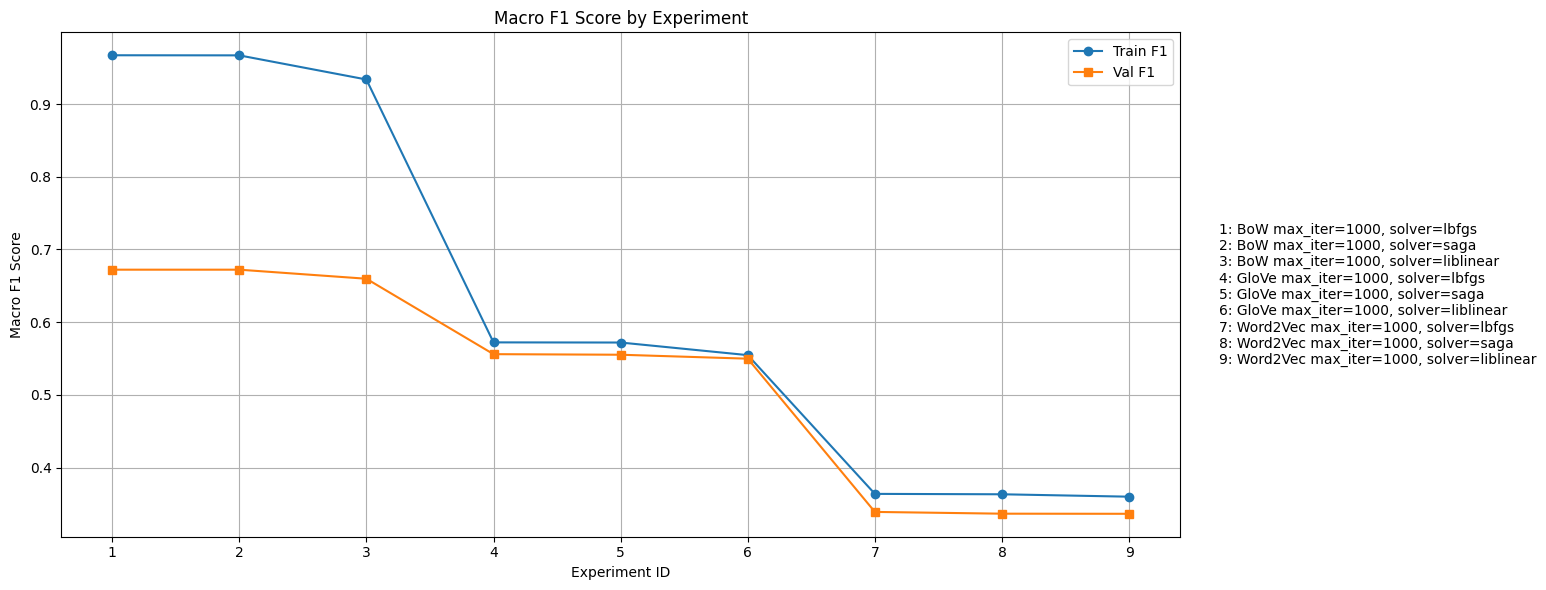

In [ ]:
# Convert results_final to a DataFrame
df_results = pd.DataFrame(results_logreg)

# Sort by validation F1 if desired
df_results = df_results.sort_values("val_f1", ascending=False).reset_index(drop=True)

# Create numerical labels for x-axis
df_results["experiment_id"] = range(1, len(df_results) + 1)

# Create mapping for legend
legend_labels = [
    f"{i+1}: {name}" for i, name in enumerate(df_results["prepro + model"])
]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_results["experiment_id"], df_results["train_f1"], marker='o', label="Train F1")
plt.plot(df_results["experiment_id"], df_results["val_f1"], marker='s', label="Val F1")

# Labels and formatting
plt.xticks(df_results["experiment_id"])  # just numbers on x-axis
plt.xlabel("Experiment ID")
plt.ylabel("Macro F1 Score")
plt.title("Macro F1 Score by Experiment")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Add a custom legend as text box
legend_text = "\n".join(legend_labels)
plt.gcf().text(1.02, 0.5, legend_text, fontsize=10, va='center')  # side legend

# Show plot
plt.show()

## 8.3. RNN & LSTM

### Pad Sequences and one hot encoding

Needed for RNN and LSTM so that all the sentences have the same lenght
Embeddings with zero are added to the end of each tweet so that they all have lenght equal to the lenght of the longer tweet

In [ ]:
#get list with lenghts of sentences
train_len = []
for i in X_train_embeddings_glove_100:
    train_len.append(len(i))

In [ ]:
max(train_len)

24

In [ ]:
X_train_pad = pad_sequences(maxlen=max(train_len),sequences=X_train_embeddings_glove_100, padding="post", dtype='float64')

In [ ]:
X_train_pad.shape

(7633, 24, 100)

In [ ]:
X_val_pad = pad_sequences(maxlen=max(train_len),sequences=X_val_embeddings_glove_100, padding="post", dtype='float64')

In [ ]:
print(X_train_pad[0][:max(train_len)])

[[ 0.0043546   0.25828001  0.88463998 ... -0.14030001  0.18065
   0.030999  ]
 [ 0.29886001  0.43645     0.38124999 ... -0.18531001 -0.51027
   0.29067001]
 [-0.15644     0.68322998  0.50617999 ... -0.75022    -0.17038
  -0.37597001]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [ ]:
y_train_encoded = tf.one_hot(y_train, depth=3)

In [ ]:
len(y_train)

7633

In [ ]:
y_val_encoded = tf.one_hot(y_val, depth=3)

In [ ]:
len(y_val)

955

In [ ]:
len(X_val_pad)

955

### Model Initialization and training

In [ ]:
# Input: padded sequences of embeddings
input_ = Input(shape=(max(train_len), dim_100))

# Masking padded tokens
mask = Masking(mask_value=0)(input_)

# Bidirectional LSTM returning sequences
lstm = Bidirectional(LSTM(units=32, return_sequences=True))(mask)

# Batch normalization
bn = BatchNormalization()(lstm)

# Pool
pooled = GlobalMaxPooling1D()(bn)

# Dropout
drop = Dropout(0.5)(pooled)

# Output layer with softmax and L2 regularization
act = Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(drop)

model = Model(input_, act)

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics = [CategoricalAccuracy(name="accuracy"), F1Score(average="macro", name="f1_score")])

# Summary
model.summary()


c:\Users\carol\Documents\mestrado\tx_mng\Lib\site-packages\keras\src\layers\layer.py:965: UserWarning: Layer 'global_max_pooling1d_6' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 24, 100)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_13        │ (None, 24, 100)   │          0 │ input_layer_13[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_13          │ (None, 24, 100)   │          0 │ input_layer_13[0… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_13 (Any)        │ (None, 24)        │          0 │ not_equal_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_15    │ (None, 24, 64)    │     34,048 │ masking_13[0][0], │
│ (Bidirectional)     │                   │            │ any_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 64)    │        256 │ bidirectional_15… │
│ (BatchNormalizatio… │                   │            │ any_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ global_max_pooli… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 3)         │        195 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,499 (134.76 KB)

 Trainable params: 34,371 (134.26 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
history=model.fit(
    X_train_pad, y_train_encoded,
    validation_data=(X_val_pad, y_val_encoded),
    batch_size=16,
    epochs=10,
    verbose=1
)

Epoch 1/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4647 - f1_score: 0.3607 - loss: 1.6022 - val_accuracy: 0.6639 - val_f1_score: 0.3915 - val_loss: 0.8528
Epoch 2/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5661 - f1_score: 0.3988 - loss: 1.2806 - val_accuracy: 0.6764 - val_f1_score: 0.4217 - val_loss: 0.8426
Epoch 3/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5948 - f1_score: 0.4233 - loss: 1.1321 - val_accuracy: 0.6890 - val_f1_score: 0.4625 - val_loss: 0.8043
Epoch 4/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6175 - f1_score: 0.4549 - loss: 1.0497 - val_accuracy: 0.6974 - val_f1_score: 0.4792 - val_loss: 0.7770
Epoch 5/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6291 - f1_score: 0.4673 - loss: 0.9929 - val_accuracy: 0.6974 - val_f1_score: 0.4934 - val_loss: 0.7512
Epoch 6/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6286 - f1_score: 0.4649 - loss: 0.9376 - val_accuracy: 0.6953 - val_f1_score: 0.5034

In [ ]:
df_history = pd.DataFrame(history.history)
# Add epoch number (starting from 1)
df_history['epoch'] = range(1, len(df_history) + 1)
df_history = df_history[['epoch'] + [col for col in df_history.columns if col != 'epoch']]
df_history.head()

,epoch,accuracy,f1_score,loss,val_accuracy,val_f1_score,val_loss
0,1,0.509760,0.377931,1.464185,0.663874,0.391506,0.852801
1,2,0.576575,0.415649,1.231468,0.676440,0.421741,0.842602
2,3,0.596882,0.429536,1.125113,0.689005,0.462540,0.804256
3,4,0.618892,0.456467,1.049479,0.697382,0.479239,0.776977
4,5,0.629897,0.468914,0.984191,0.697382,0.493433,0.751164


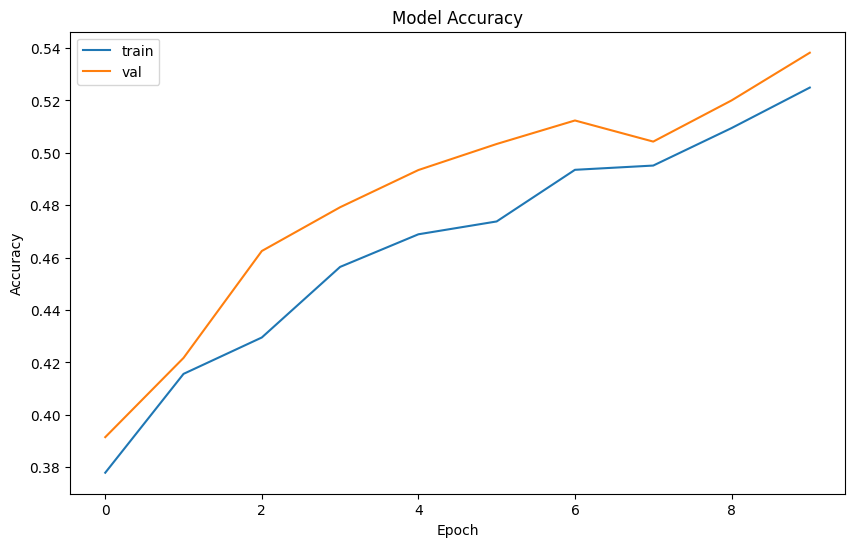

In [ ]:
plt.figure(figsize =(10, 6))
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')

plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def get_metric(X_test, y_test, model_name):
    print(f"\nEvaluating model: {model_name}")
    #model = load_model(model_name)
    pred_y = model.predict(X_test)

    y_pred = []
    for doc in pred_y:
        y_pred.append(np.argmax(doc, axis=None, out=None))

    train_report = classification_report(y_test, y_pred, target_names=['bearish', 'bullish', 'neutral'], output_dict=True)

    # for label in ['bearish', 'bullish', 'neutral']:
    #     metrics = train_report[label]
    #     print(f"\nClass: {label}")
    #     print(f"  Precision: {metrics['precision']:.4f}")
    #     print(f"  Recall:    {metrics['recall']:.4f}")
    #     print(f"  F1-score:  {metrics['f1-score']:.4f}")
    # print(f"\nMacro Avg F1-score: {train_report['macro avg']['f1-score']:.4f}")


    return round(train_report['macro avg']['precision'], 4), round(train_report['macro avg']['recall'], 4), round(train_report['macro avg']['f1-score'], 4)

In [ ]:
get_metric(X_val_pad, y_val, model)


Evaluating model: <Functional name=functional_12, built=True>
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Class: bearish
  Precision: 0.6000
  Recall:    0.2292
  F1-score:  0.3317

Class: bullish
  Precision: 0.5854
  Recall:    0.3731
  F1-score:  0.4557

Class: neutral
  Precision: 0.7426
  Recall:    0.9337
  F1-score:  0.8272

Macro Avg F1-score: 0.5382


(0.6427, 0.512, 0.5382)

## 8.4. Transformer

### 8.4.1. RoBERTa

__`Step XX`__ Set Up the Model (RoBERTa + Custom Classifier).

In [29]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch

class RoBERTaSentimentClassifier(nn.Module):
    def __init__(self, model_name="cardiffnlp/twitter-roberta-base-sentiment", num_labels=3, dropout=0.1):
        super(RoBERTaSentimentClassifier, self).__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits


__`Step XX`__ Tokenize & Dataset Preparation.

In [30]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx])
        }

train_dataset = TextDataset(X_train_cleaned, y_train.tolist(), tokenizer)
val_dataset = TextDataset(X_val_cleaned, y_val.tolist(), tokenizer)
test_dataset = TextDataset(X_test_cleaned, y_test.tolist(), tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

__`Step XX`__ Training the Classifier.

In [31]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RoBERTaSentimentClassifier().to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

def train_tranformer(train_loader, val_loader, model):

  optimizer = AdamW(model.parameters(), lr=2e-5)
  criterion = CrossEntropyLoss()

  for epoch in range(3):
      model.train()
      total_loss = 0
      for batch in train_loader:
          input_ids = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels = batch["labels"].to(device)

          optimizer.zero_grad()
          outputs = model(input_ids, attention_mask)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          total_loss += loss.item()

      print(f"Epoch {epoch + 1} — Loss: {total_loss / len(train_loader):.4f}")


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Epoch 1 — Loss: 0.5584
Epoch 2 — Loss: 0.3597
Epoch 3 — Loss: 0.2317


__`Step XX`__ Evaluate the Model

In [48]:
from sklearn.metrics import classification_report

# model.eval()
# all_preds, all_labels = [], []


def get_metrics_transformers(data_loader, model):
  model.eval()
  all_preds, all_labels = [], []
  with torch.no_grad():
      for batch in data_loader:
          input_ids = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels = batch["labels"].to(device)

          outputs = model(input_ids, attention_mask)
          preds = torch.argmax(outputs, dim=1)

          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())
      report=classification_report(all_labels, all_preds, target_names=["0", "1", "2"],output_dict=True, digits=4)

      # Keep only precision, recall, f1-score for each class and macro avg
      filtered_report = {
        label: {
            "precision": report[label]["precision"],
            "recall": report[label]["recall"],
            "f1-score": report[label]["f1-score"]
        }
        for label in ["0", "1", "2", "macro avg"]
      }

      df_metrics = pd.DataFrame.from_dict(filtered_report, orient="index")
      return df_metrics

In [47]:
print(get_metrics_transformers(train_loader, model))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1154
           1       0.94      0.98      0.96      1537
           2       0.99      0.98      0.98      4942

    accuracy                           0.97      7633
   macro avg       0.97      0.96      0.96      7633
weighted avg       0.97      0.97      0.97      7633



In [ ]:
print(get_metrics_transformers(val_loader, model))

In [ ]:
print(get_metrics_transformers(test_loader, model))

### 8.4.2. DistilBERT uncased

__`Step XX`__ Set Up the Model (DistilBERT + Custom Classifier).

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch

# Updated model name
MODEL_NAME = "assemblyai/distilbert-base-uncased-sst2"

class DistilBERTSentimentClassifier(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_labels=3, dropout=0.1):
        super(DistilBERTSentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits


__`Step XX`__ Tokenize & Dataset Preparation.

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx])
        }

train_dataset = TextDataset(X_train_cleaned, y_train.tolist(), tokenizer)
val_dataset = TextDataset(X_val_cleaned, y_val.tolist(), tokenizer)


__`Step XX`__ Training the Classifier.

In [ ]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBERTSentimentClassifier().to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = CrossEntropyLoss()

for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1} — Loss: {total_loss / len(train_loader):.4f}")


Epoch 1 — Loss: 0.6182
Epoch 2 — Loss: 0.3797
Epoch 3 — Loss: 0.2120


__`Step XX`__ Evaluate the Model

In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=["0", "1", "2"]))


              precision    recall  f1-score   support

           0       0.62      0.73      0.67       288
           1       0.72      0.73      0.73       385
           2       0.89      0.85      0.87      1236

    accuracy                           0.80      1909
   macro avg       0.74      0.77      0.75      1909
weighted avg       0.81      0.80      0.81      1909



### 8.4.3. XLM RoBERTa

__`Step XX`__ Set Up the Model (XLM RoBERTa + Custom Classifier).

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch

# Updated model name
MODEL_NAME = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

class XLMROBERTASentimentClassifier(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_labels=3, dropout=0.1):
        super(XLMROBERTASentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

__`Step XX`__ Tokenize & Dataset Preparation.

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx])
        }

train_dataset = TextDataset(X_train_cleaned, y_train.tolist(), tokenizer)
val_dataset = TextDataset(X_val_cleaned, y_val.tolist(), tokenizer)

__`Step XX`__ Training the Classifier.

In [ ]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = XLMROBERTASentimentClassifier().to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = CrossEntropyLoss()

for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1} — Loss: {total_loss / len(train_loader):.4f}")


Some weights of XLMRobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 — Loss: 0.6494
Epoch 2 — Loss: 0.4366
Epoch 3 — Loss: 0.2935


__`Step XX`__ Evaluate the Model

In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=["0", "1", "2"]))

              precision    recall  f1-score   support

           0       0.76      0.64      0.70       288
           1       0.70      0.80      0.75       385
           2       0.89      0.89      0.89      1236

    accuracy                           0.83      1909
   macro avg       0.79      0.78      0.78      1909
weighted avg       0.83      0.83      0.83      1909



### 8.4.4. FinBERT

__`Step XX`__ Set Up the Model (FinBERT + Custom Classifier).

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch

# Updated model name
MODEL_NAME = "ProsusAI/finbert"

class FinBERTSentimentClassifier(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_labels=3, dropout=0.1):
        super(FinBERTSentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

__`Step XX`__ Tokenize & Dataset Preparation.

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx])
        }

train_dataset = TextDataset(X_train_cleaned, y_train.tolist(), tokenizer)
val_dataset = TextDataset(X_val_cleaned, y_val.tolist(), tokenizer)

__`Step XX`__ Training the Classifier.

In [ ]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FinBERTSentimentClassifier().to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = CrossEntropyLoss()

for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1} — Loss: {total_loss / len(train_loader):.4f}")


Epoch 1 — Loss: 0.5872
Epoch 2 — Loss: 0.3568
Epoch 3 — Loss: 0.2023


__`Step XX`__ Evaluate the Model

In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=["0", "1", "2"]))

              precision    recall  f1-score   support

           0       0.65      0.68      0.67       288
           1       0.71      0.77      0.74       385
           2       0.90      0.86      0.88      1236

    accuracy                           0.82      1909
   macro avg       0.75      0.77      0.76      1909
weighted avg       0.82      0.82      0.82      1909



### 8.4.5. DistilBERT Cased

__`Step XX`__ Set Up the Model (DIstilBERT + Custom Classifier).

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch

# Updated model name
MODEL_NAME = "distilbert-base-cased"

class DistilBERTCSentimentClassifier(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_labels=3, dropout=0.1):
        super(DistilBERTCSentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

__`Step XX`__ Tokenize & Dataset Preparation.

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx])
        }

train_dataset = TextDataset(X_train_cleaned, y_train.tolist(), tokenizer)
val_dataset = TextDataset(X_val_cleaned, y_val.tolist(), tokenizer)

__`Step XX`__ Training the Classifier.

In [ ]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBERTCSentimentClassifier().to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = CrossEntropyLoss()

for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1} — Loss: {total_loss / len(train_loader):.4f}")


Epoch 1 — Loss: 0.6541
Epoch 2 — Loss: 0.3653
Epoch 3 — Loss: 0.1860


__`Step XX`__ Evaluate the Model

In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=["0", "1", "2"]))

              precision    recall  f1-score   support

           0       0.72      0.61      0.66       288
           1       0.74      0.68      0.71       385
           2       0.86      0.91      0.88      1236

    accuracy                           0.82      1909
   macro avg       0.77      0.73      0.75      1909
weighted avg       0.81      0.82      0.81      1909



`Conclusion`: The transformer who performed the best was RoBERTa.

# 9. Evaluation